In [1]:
using Plots, ColorSchemes

include("setup.jl")
include("simulate.jl")
include("utils.jl")
include("optimal_filter.jl")
include("filters.jl")

optimal_filter (generic function with 1 method)

In [14]:
## Setup ##

# grid(p,q,P,Q)
gr = grid(60, 60, 40000, 40000)

# timestep for simulation
dt = 1.0

#time between observations
obs_dt = 5.0

# total time
total_time = 250

# Gravitational constant
grav = 9.80665

# Depth of sea, uniform for now
depth = 1500
depth_m = ones(p+1, q+1).*depth

# Parameters for boundary conditions, as in Cerjan (1985)
boundary_damping = 0.015
boundary_size = 15 #boundary size given in terms of number of points from edge.


# stations locations as 2d-coords
# stat_locs = [
#     (10,10),
#     (10,20),
#     (10,30),
#     (20,10),
#     (20,20),
#     (20,30),
#     (30,10),
#     (30,20),
#     (30,30)
# ]

# Alternative for setting up a uniformly spaced square grid of stations 
# Usage is: uniform_stations(grid, square root of num_stations, num_points from boundary of stations)
# So uniform_stations(gr,6, 16) gives a grid of 36 stations in centre of grid that are 16 grid points from edge of grid.
stat_locs = uniform_stations(gr,6, 16)

# sigma value of observation noise
sigma_obs = 0.01
error_dist = MvNormal(Diagonal(fill(sigma_obs^2, length(stat_locs))))

# values for correlation function
# correlation length for gaussian random field, if this is too large grf sampling fails as lambda has negative values
l = 5000.0 
# sigma values for height and velocity fields
height_sigma = 0.1 
vel_sigma = 30

# iniital value of max height i.e. height the intial wave falls from
initial_max_height = 30

# radius of non-zero height area in iniital conditions
initial_spread = 3000

#Parameters for filters
num_particles = 100
min_ess_ratio = 0.5

# setup initial height, x vel, y vel and matrix for boundary conditions
height_m = initial_max_height*initial_height(p+1, q+1, dx, dy, initial_spread)
x_vel_m = zeros(p+1, q+1)
y_vel_m = zeros(p+1, q+1)
boundary_m = boundary_conditions(boundary_size, p+1, q+1, boundary_damping)

61×61 Array{Float64,2}:
 0.950635  0.950635  0.950635  0.950635  …  0.950635  0.950635  0.950635
 0.950635  0.956858  0.956858  0.956858     0.956858  0.956858  0.950635
 0.950635  0.956858  0.962689  0.962689     0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119     0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119     0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119  …  0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119     0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119     0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119     0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119     0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119  …  0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119     0.962689  0.956858  0.950635
 0.950635  0.956858  0.962689  0.968119     0.962689  0.956858  0.950635
 ⋮                         

In [3]:
# Simulate wave and create observations.
true_pos = Array{Float64}[]
observations = Array{Float64}[]
height_m += sample_uncond_grf(l, height_sigma, gr)
x_vel_m += sample_uncond_grf(l, vel_sigma, gr)
y_vel_m += sample_uncond_grf(l, vel_sigma, gr)
for i in 1:Int(total_time/obs_dt)
    for t in 1:Int(obs_dt/dt)
        new_x_vel_m, new_y_vel_m, new_height_m = timestep(
            height_m, x_vel_m, y_vel_m, dx, dy, dt, depth_m, boundary_m, grav
        )
        global x_vel_m = new_x_vel_m
        global y_vel_m = new_y_vel_m
        global height_m = new_height_m
    end
    global x_vel_m += sample_uncond_grf(l, vel_sigma, gr)
    global y_vel_m += sample_uncond_grf(l, vel_sigma, gr)
    global height_m += sample_uncond_grf(l, height_sigma, gr) 
    push!(true_pos, height_m)
    push!(observations, A1(vec(height_m), stat_locs, gr) + rand(error_dist))
end

┌ Info: Saved animation to 
│   fn = /Users/neilfoster/tsunami_model/tmp.gif
└ @ Plots /Users/neilfoster/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/neilfoster/tsunami_model/tmp.gif")
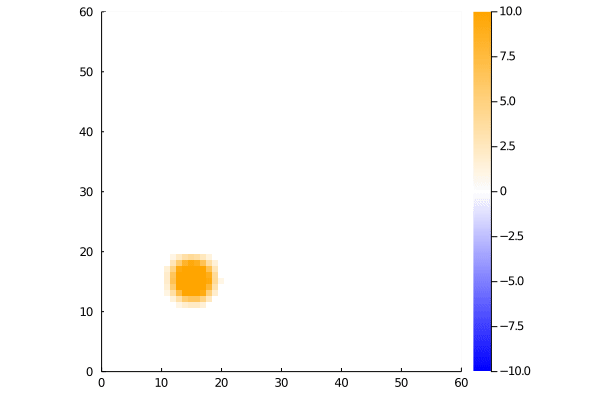

In [4]:
anim = @animate for i in 1:size(true_pos)[1]
    heatmap(threshold_height(true_pos[i],1), clims=(-10, 10), c=cgrad([:blue, :white, :orange]), aspect_ratio=:equal, xlims=(0, gr.p), ylims=(0,gr.q))
end
gif(anim, fps = 5)

In [5]:
# BOOTSTRAP

bs_particles, bs_lw, bs_ess_log = bootstrap(100, l, height_sigma, vel_sigma, gr, 0.5, observations)
print("Bootstrap complete")

Bootstrap complete

In [6]:
# OPTIMAL FILTER

of_particles, of_lw, of_ess_log =  optimal_filter(100, l, height_sigma, vel_sigma, gr, 0.5, observations)
print("Optimal filter complete")

Optimal filter complete

In [7]:
function weighted_average(heights, log_weights)
    mean_height = zeros(size(heights[1]))
    for (h, w) in zip(heights, exp.(log_weights))
        mean_height += w*h
    end
    return mean_height
end

weighted_average (generic function with 1 method)

In [8]:

# estimated wave from mean of optimal filter
of_wave = []
for i in 1:length(of_particles[1])
    a = weighted_average([of_particles[j][i][1] for j in 1:length(of_particles)], of_lw[i])
    push!(of_wave, a)
end

# estimated wave from mean of bootstrap filter
bs_wave = []
for i in 1:length(bs_particles[1])
    a = weighted_average([bs_particles[j][i][1] for j in 1:length(bs_particles)], bs_lw[i])
    push!(bs_wave, a)
end

┌ Info: Saved animation to 
│   fn = /Users/neilfoster/tsunami_model/tmp.gif
└ @ Plots /Users/neilfoster/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/neilfoster/tsunami_model/tmp.gif")
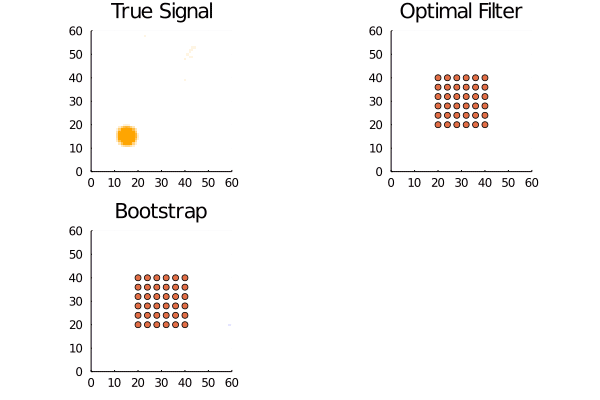

In [10]:
# plot animations of true wave and estimations via filters.

clim_val = 5 # Max/min height value in plots
min_height = 0.5 # heights such that abs(height) < min_height are set to zero for visualisation purposes

col_map = cgrad([:blue, :white, :orange])
anim = @animate for i in 1:length(true_pos)
    hms = [
        heatmap(
            threshold_height(true_pos[i],min_height),
            aspect_ratio=:equal, ylims=(0,gr.q), xlims=(0,gr.p), clims=(-clim_val, clim_val), colorbar=false, c=col_map, title="True Signal"
            ),
        heatmap(
            threshold_height(of_wave[i+1],min_height),
            aspect_ratio=:equal, ylims=(0,gr.q), xlims=(0,gr.p), clims=(-clim_val, clim_val), colorbar=false, c=col_map, title="Optimal Filter"
            ),
        heatmap(
            threshold_height(bs_wave[i+1], min_height),
            aspect_ratio=:equal, ylims=(0,gr.q), xlims=(0,gr.p), clims=(-clim_val, clim_val), colorbar=false, c=col_map, title="Bootstrap"
        )
    ]
    plot(hms..., layout=3)
    scatter!([x[1] for x in stat_locs], [x[2] for x in stat_locs], subplot=2, legend=false)
    scatter!([x[1] for x in stat_locs], [x[2] for x in stat_locs], subplot=3, legend=false)
end
gif(anim, fps = 5)

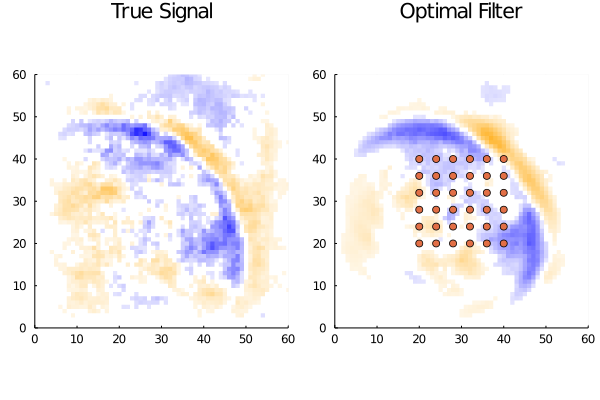

In [19]:
# plot for a single frame true wave and estimated

i = 40 # choice of frame
clim_val = 5 # Max/min height value in plots
min_height = 0.5 # heights such that abs(height) < min_height are set to zero for visualisation purposes
col_map = cgrad([:blue, :white, :orange])

hms = [
    heatmap(
        threshold_height(true_pos[i],min_height),
        aspect_ratio=:equal, ylims=(0,gr.q), xlims=(0,gr.p), clims=(-clim_val, clim_val), colorbar=false, c=col_map, title="True Signal"
        ),
    heatmap(
        threshold_height(of_wave[i+1],min_height),
        aspect_ratio=:equal, ylims=(0,gr.q), xlims=(0,gr.p), clims=(-clim_val, clim_val), colorbar=false, c=col_map, title="Optimal Filter"
        ),
#     heatmap(
#         threshold_height(bs_wave[i+1], min_height),
#         aspect_ratio=:equal, ylims=(0,gr.q), xlims=(0,gr.p), clims=(-clim_val, clim_val), colorbar=false, c=col_map, title="Bootstrap"
#     )
]
plot(hms..., layout=2)
scatter!([x[1] for x in stat_locs], [x[2] for x in stat_locs], subplot=2, legend=false)


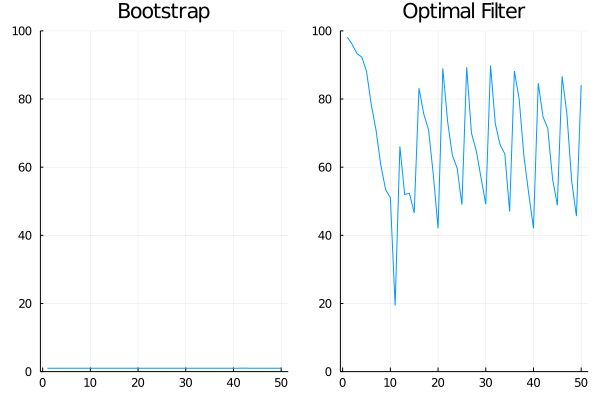

In [16]:
#plots of effective sample size for bootstrap and optimal filters
lplts = [
    plot(bs_ess_log, ylims=(0,num_particles), title="Bootstrap", legend=false),
    plot(of_ess_log, ylims=(0,num_particles), title="Optimal Filter", legend=false)
]
plot(lplts..., layout=2)